# MNIST

In this Jupyter notebook, you will train three neural networks on the MNIST dataset.
Starting with a (very) simple ANN, you will proceed with a deeper, but still simple model. After that, you will evalaute how a convolutional neural network performs.

Last but not Least you are given the opportunity to use Keras, to build a custom model on your own.

## Import the dataset.

Tensorflow includes a few popular datasets, which makes using them very convenient. Of course, the MNIST dataset is also supported. 
It is splitted into a training set (60000 images) and a test set (10000 images) inherently. We additionally split the training set into a slightly smaller training set (54000 images) and a validation set (6000 images). The latter is used to measure the performance on unseen data in the training process.

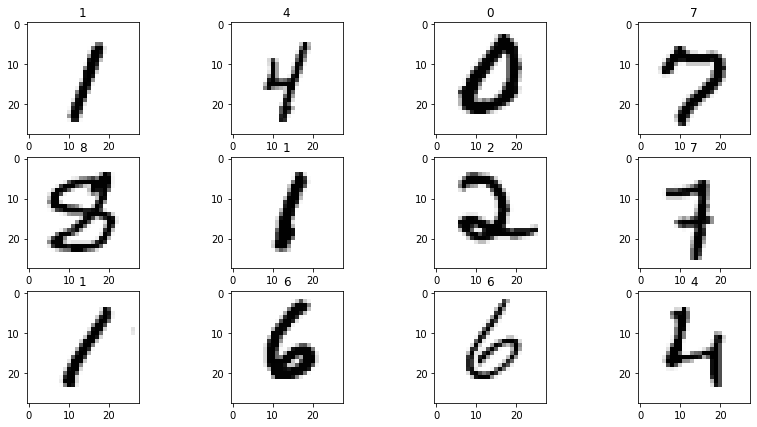

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np


(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

plt.rcParams["figure.figsize"] = (14,7)
fig, axs = plt.subplots(3,4)
it = iter(ds_train)
data = next(it)
for x in range(0,3):
    for y in range(0,4):
        axs[x][y].imshow(data[0].numpy(), cmap='Greys')
        axs[x][y].set_title(data[1].numpy()) 
        data = next(it)

## Prepare the dataset

The MNIST images are in unint8. They have to be normalized (divided by 255), to work with the ANN.
The dataset comes as a tf.data.Dataset, which is optimized for training ANNs. It allows to apply the follwing steps with ease:
1. Normalize the data (divide by 255)
2. Cache: The first time the data is used, it will be cached in memory
3. Shuffle the data (not necessary for test/val set)
4. Batch: The tf.data.Dataset object will hand over batches in the given size, the batch size is defined this way (and not in the fit() method)
5. Prefetch: Already load new instances, while the previous is processed. Speeds up training, because the ANN does not have to wait for its data.

Note: If you ant to change the batch size later, you have to change it in this section and run it again.

In [3]:
def normalizeIMG(image, label):
    return tf.cast(image/255, tf.float32), label

ds_train = ds_train.map(normalizeIMG, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalizeIMG, num_parallel_calls=tf.data.AUTOTUNE)
#save true labels as numpy array for later usage in confusion matrix
y_true= []
for image, label in tfds.as_numpy(ds_test):
    y_true.append(label)
y_true = np.array(y_true)   
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(normalizeIMG, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(32)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

## A (very) simple ANN

Your first artificial neural network will be a really simple model, that has only one hidden layer.

### Define

Define the model, it should have the follwing layers:

1. Flatten layer (convert input of 28x28 images to a 784-1D input)
2. Dense layer with 20 neurons and ReLu activation function
3. Dense layer with 10 neurons and Softmax (why?) activation function

In [4]:
simple = keras.Sequential()

simple.add(keras.layers.Flatten(input_shape=(28,28)))
simple.add(keras.layers.Dense(20, activation="relu"))
simple.add(keras.layers.Dense(10, activation="softmax"))

simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


### Train

Now that the model is defined, you can compile and train it.
- Compile the model using "sgd" optimizer and SparseCategoricalCrossentropy loss, SparseCategoricalAccuracy should be calculated as an additional metric. SparseCategoricalCrossentropy is used when there are two or more labels (here 10) and the labels are given as integers (which is the case for the given dataset). 
-  Fit the model for 10 epochs using the training data, also hand over the valdation set as validation data.

In [5]:
simple.compile(optimizer="sgd", 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

historySimple = simple.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
)

Epoch 1/10
1688/1688 [==============================] - 36s 12ms/step - loss: 0.8367 - sparse_categorical_accuracy: 0.7749 - val_loss: 0.4358 - val_sparse_categorical_accuracy: 0.8863
Epoch 2/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.3524 - val_sparse_categorical_accuracy: 0.9065
Epoch 3/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.3257 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3191 - val_sparse_categorical_accuracy: 0.9148
Epoch 4/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.2999 - sparse_categorical_accuracy: 0.9144 - val_loss: 0.3007 - val_sparse_categorical_accuracy: 0.9178
Epoch 5/10
1688/1688 [==============================] - 18s 10ms/step - loss: 0.2829 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.2885 - val_sparse_categorical_accuracy: 0.9232
Epoch 6/10
1688/1688 [==============================] - 19s 11ms/step - loss: 0.

### Evaluate

The follwing code plots training and validation set accuracy against epoch. It can be useful to check if the model is overfitting the training data, this might be the case when training accuracy goes up while validation accuracy stagnates.

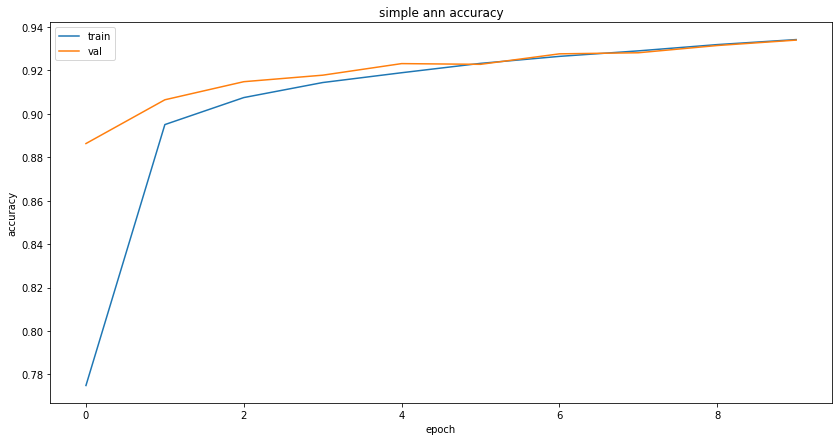

In [6]:
#plot the training & validation loss
plt.plot(historySimple.history['sparse_categorical_accuracy'])
plt.plot(historySimple.history['val_sparse_categorical_accuracy'])
plt.title('simple ann accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Confusion matrix

Analyse which numbers are often confused.

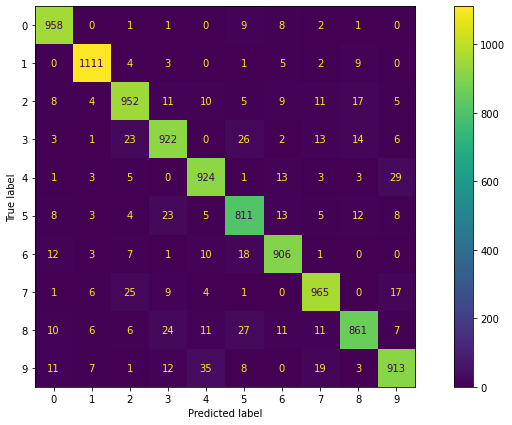

In [7]:
#model outputs a probability for each label (label equal index -> argmax)
y_pred = np.argmax(simple.predict(ds_test), axis=1)

#the numpy array y_true was created above
cm_simple = confusion_matrix(y_true=y_true, y_pred=y_pred)

disp = ConfusionMatrixDisplay(cm_simple)
disp.plot()
plt.show()

## A deeper model

The next model will be a deeper model (i.e. it has more layers), that also features Dropout layers for regularization.

### Define

Define the model, it should have the follwing layers:

1. Flatten layer (28x28 input_shape)
2. Dense layer, 40 neurons, Relu activation
3. 50% Dropout layer (for regularization)
4. Dense layer, 40 neurons, Relu activation
5. Dense layer, 40 neurons, Relu activation
6. 50% Dropout layer (for regularization)
7. Dense layer, 40 neurons, Relu activation
8. Dense layer, 10 neurons, Softmax activation

In [8]:
dnn = keras.Sequential()

dnn.add(keras.layers.Flatten(input_shape=(28,28)))
dnn.add(keras.layers.Dense(40, activation="relu"))
dnn.add(keras.layers.Dropout(0.5))
dnn.add(keras.layers.Dense(40, activation="relu"))
dnn.add(keras.layers.Dense(40, activation="relu"))
dnn.add(keras.layers.Dropout(0.5))
dnn.add(keras.layers.Dense(40, activation="relu"))
dnn.add(keras.layers.Dense(10, activation="softmax"))

dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                31400     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)               

### Train

Train the model for 10 epochs, using the same parameters as above.

In [9]:
dnn.compile(optimizer="sgd", 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

historyDNN = dnn.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
)

Epoch 1/10
1688/1688 [==============================] - 27s 15ms/step - loss: 1.8639 - sparse_categorical_accuracy: 0.3661 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.7627
Epoch 2/10
1688/1688 [==============================] - 24s 14ms/step - loss: 1.0693 - sparse_categorical_accuracy: 0.6423 - val_loss: 0.5203 - val_sparse_categorical_accuracy: 0.8623
Epoch 3/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.8361 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.4083 - val_sparse_categorical_accuracy: 0.9007
Epoch 4/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.7351 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.3620 - val_sparse_categorical_accuracy: 0.9115
Epoch 5/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.3278 - val_sparse_categorical_accuracy: 0.9165
Epoch 6/10
1688/1688 [==============================] - 28s 16ms/step - loss: 0.

### Evaluate

Evaluate the deeper model.

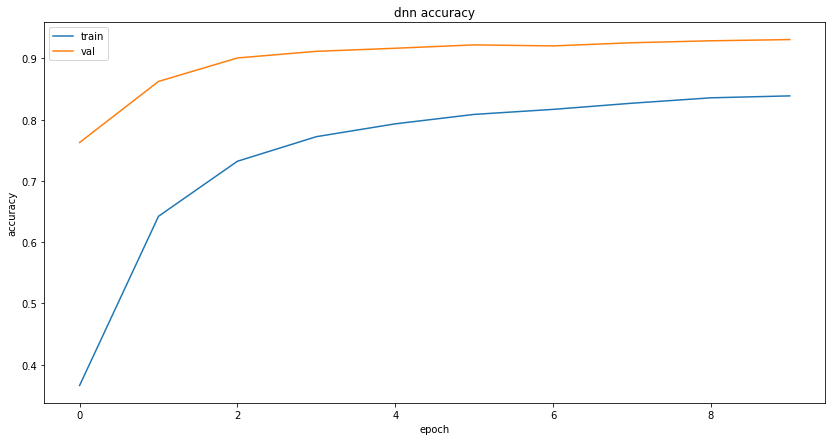

In [10]:
#plot the training & validation loss
plt.plot(historyDNN.history['sparse_categorical_accuracy'])
plt.plot(historyDNN.history['val_sparse_categorical_accuracy'])
plt.title('dnn accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The training accuracy is always below the validation accuracy. This might be surprising, but it comes from the fact, that the Dropout is only active while training.

## A convolutional neural network

Next, you will build a more complex convolutional neural network.

### Define

Define the model, it should have the follwing layers:

1. Input, to tell Keras which size the input has. This layers is not mandatory, but summary() wont work without it.
2. Conv2D, 6 feature maps, 5x5 kernel, (1,1) stride, 'same' padding (fill with zeros), ReLu activation
3. AveragePooling2D, 2x2 pool size, (2,2) stride, 'valid' padding (no padding)
4. Conv2D, 16 feature maps, 5x5 kernel, (1,1) stride, 'valid' padding, ReLu activation
5. AveragePooling2D, 2x2 pool size, (2,2) stride, 'valid' padding (no padding)
6. Conv2D, 120 feature maps, 5x5 kernel, (1,1) stride, 'valid' padding, ReLu activation
7. Flatten
8. Dense, 84 neurons, ReLu activation
9. Dense, 10 neurons, Softmax activation

In [11]:
cnn = keras.Sequential()

cnn.add(keras.Input(shape=(28,28,1)))

cnn.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
cnn.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
cnn.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(84, activation='relu'))
cnn.add(keras.layers.Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

### Train

Train the model for 10 epochs.

In [12]:
cnn.compile(optimizer="sgd", 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

historyCNN = cnn.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
)

Epoch 1/10
1688/1688 [==============================] - 131s 43ms/step - loss: 0.8837 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.2778 - val_sparse_categorical_accuracy: 0.9160
Epoch 2/10
1688/1688 [==============================] - 45s 26ms/step - loss: 0.2323 - sparse_categorical_accuracy: 0.9292 - val_loss: 0.2187 - val_sparse_categorical_accuracy: 0.9337
Epoch 3/10
1688/1688 [==============================] - 43s 25ms/step - loss: 0.1596 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1341 - val_sparse_categorical_accuracy: 0.9598
Epoch 4/10
1688/1688 [==============================] - 43s 25ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.9614 - val_loss: 0.1098 - val_sparse_categorical_accuracy: 0.9690
Epoch 5/10
1688/1688 [==============================] - 43s 25ms/step - loss: 0.1014 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.1081 - val_sparse_categorical_accuracy: 0.9692
Epoch 6/10
1688/1688 [==============================] - 43s 25ms/step - loss: 0

### Evaluate

Evaluate the model.

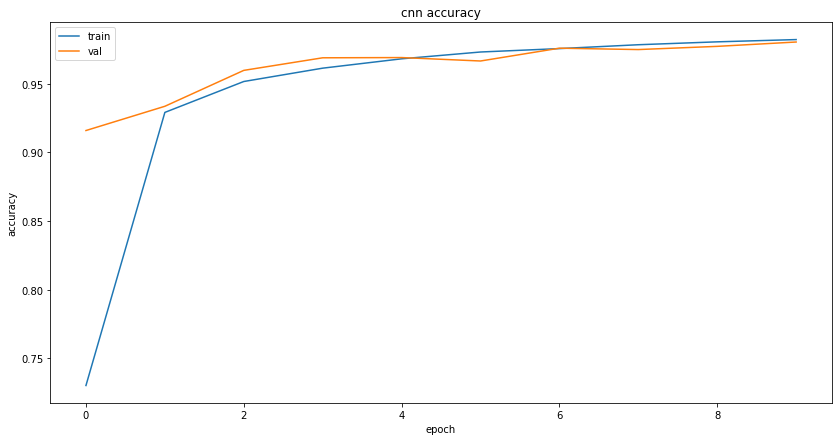

In [13]:
#plot the training & validation loss
plt.plot(historyCNN.history['sparse_categorical_accuracy'])
plt.plot(historyCNN.history['val_sparse_categorical_accuracy'])
plt.title('cnn accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Final evalation

After you have build different models to recognize digits from the MNIST dataset, you can compare all the models on the test set.

In [14]:
#evaluate the accuracy on the test set
scoreSimple = simple.evaluate(ds_test, return_dict=True)
print("Simple ANN:")
print("Test loss: " + str(scoreSimple['loss']))
print("Test accuracy: " + str(scoreSimple['sparse_categorical_accuracy']))


#evaluate the accuracy on the test set
scoreDNN = dnn.evaluate(ds_test, return_dict=True)
print("Deeper network:")
print("Test loss: " + str(scoreDNN['loss']))
print("Test accuracy: " + str(scoreDNN['sparse_categorical_accuracy']))


#evaluate the accuracy on the test set
scoreCNN = cnn.evaluate(ds_test, return_dict=True)
print("CNN:")
print("Test loss: " + str(scoreCNN['loss']))
print("Test accuracy: " + str(scoreCNN['sparse_categorical_accuracy']))

313/313 [==============================] - 10s 9ms/step - loss: 0.2342 - sparse_categorical_accuracy: 0.9323
Simple ANN:
Test loss: 0.23424167931079865
Test accuracy: 0.9322999715805054
313/313 [==============================] - 3s 9ms/step - loss: 0.2576 - sparse_categorical_accuracy: 0.9308
Deeper network:
Test loss: 0.25757884979248047
Test accuracy: 0.9308000206947327
313/313 [==============================] - 6s 18ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9821
CNN:
Test loss: 0.05456375703215599
Test accuracy: 0.9821000099182129


## Playground

If you would like to change the models above or even build your own model, you can use this section to be creative.

### Define

Define you model, you can use the [keras documentation](https://keras.io/api/), if you want to know more about other layers.

In [15]:
mymodel = keras.Sequential()

mymodel.add(...)

mymodel.summary

TypeError: The added layer must be an instance of class Layer. Found: Ellipsis

### Train

Train the model. Again, you can use the [keras documentation](https://keras.io/api/), if you want to know more (for example other optimizers).

In [ ]:
mymodel.compile(optimizer="sgd", 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

historyMY = mymodel.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
)

### Evaluate

Finally evaluate your model, how does it perform?

In [ ]:
#plot the training & validation loss
plt.plot(historyMY.history['sparse_categorical_accuracy'])
plt.plot(historyMY.history['val_sparse_categorical_accuracy'])
plt.title('mymodel accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#evaluate the accuracy on the test set
scoreMY = mymodel.evaluate(ds_test, return_dict=True)
print("Custom model:")
print("Test loss: " + str(scoreMY['loss']))
print("Test accuracy: " + str(scoreMY['sparse_categorical_accuracy']))